# Display Some Images

In [1]:
import os
# import shutil
# import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

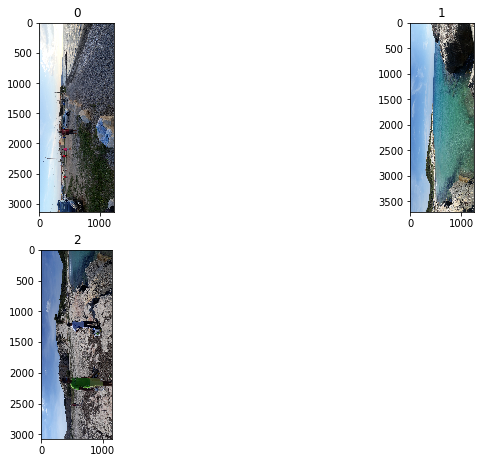

In [2]:
# One folder with many images inside
src_folder = "C:\data\class_unsup\poc2"

def plot_some_images(src_folder, max_images=5, figsize=(12, 16)):
    # Set up a figure of an appropriate size
    fig = plt.figure(figsize=(12, 16))
    
    img_num = 0

    # loop through the images
    filenames = os.listdir(src_folder)
    for file in filenames:
        
        imgFile = os.path.join(src_folder, file)
        img = Image.open(imgFile)
        # Add the image to the figure (which will have 4 rows and enough columns to show a file from each folder)
        a=fig.add_subplot(4,2,img_num + 1)
        
        imgplot = plt.imshow(img)
        # Add a caption with the folder name
        a.set_title(img_num)
        img_num = img_num + 1  
        if img_num == max_images : break
    
plot_some_images(src_folder, max_images=3, figsize=(12, 16))

# Preprocess and Normalize Images

In [3]:
import numpy as np

In [4]:
def resize_image(src_image, size=(128,128), bg_color="white"): 
    from PIL import Image, ImageOps 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

In [5]:
def load_images(src_folder, size=(128,128)):
    
    # loop through the images
    # Load .jpg only
    filenames = [jpg for jpg in os.listdir(src_folder) if jpg.endswith(".jpg")]
    
    # Define empty arrays where we will store our images and labels
    images = []
            
    for file in filenames:
        imgFile = os.path.join(src_folder, file)
        # open & resize
        img = Image.open(imgFile)
        img = resize_image(img, size, bg_color="white")
        
        # Convert to numpy arrays
        img = np.array(img, dtype=np.float32)

        # Normalise the images
        img /= 255
        
        # Now we add it to our array
        images.append(img)

    return np.array(images, dtype=np.float32)

In [6]:
images = load_images(src_folder)

# Load Model and Make Predictions On Images